<a href="https://colab.research.google.com/github/antonsysoev/DeepLearning/blob/main/transfer_learning_images_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

transfer learning

Каждый раз, обучая сеть, мы сначала рандомно инициализируем веса, а после в ходе бэкпропа обучаем модель. Если мы сразу же угадываем хорошие веса, модель сходится быстрее. Иногда можно брать в качестве инициализации веса, полученные другими исследователями и на их основе дообучать модель под свой выход. Это здорово упрощает задачу обучения и экономит недели работы.

- __Transfer learning__ - это когда ты заморозил все веса, кроме последних слоёв, а последнии слои дообучил под свою задачу 
- __Finetuning__ - это когда ты использовал веса предобученной модели как инициализацию и менял в ходе дообучения все веса модели

In [1]:
import tensorflow as tf
tf.__version__ 

'2.11.0'

In [2]:
from tensorflow.keras import Sequential, Model, layers

import numpy as np
import random
from tqdm import tqdm

import matplotlib.pyplot as plt 
%matplotlib inline


Большинство предобученных на ImageNet моделей есть в Tensorflow. Мы можем использовать их для решения своих задач. 

Давайте попробуем взять[архитектуру MobileNetV2](https://arxiv.org/abs/1801.04381) и применить к  задаче классификации кошек и собак. Эта модель была собрана и обучена на ImageNet в апреле 2018 года. Если говорить грубо, MobileNet это почти как Inception, но меньше. 

In [3]:
# как зоопарк подгружаем
import tensorflow.keras.applications as zoo  

Попробуем взять из зоопарка предобученную модель и применить её для прогнозирования.

In [4]:
model = zoo.MobileNetV2(include_top=True, weights='imagenet')

14536120/14536120 [==============================] - 1s 0us/step


Опция `weights` отвечает за то, на каком датасете предобучена модель. Опция `include_top` отвечает за то, скачиваем мы модель полностью или только `feature extractor`, то есть только первые слои. Мы скачали всё. 

In [5]:
# Узнаем размерность входа и выхода
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Теперь попробуем что-нибудь спрогнозировать. В модуле `keras.utis` есть функция `get_file`, которая умеет скачивать и разархивировать разные файлы. Будем использовать её для скачки картинок по ссылкам. 

120478/120478 [==============================] - 1s 4us/step
/root/.keras/datasets/cat.jpg


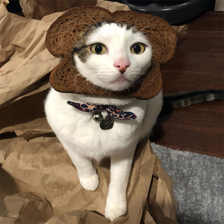

In [6]:
from tensorflow.keras.utils import get_file

import PIL.Image
import numpy as np

href = 'https://sadanduseless.b-cdn.net/wp-content/uploads/2019/06/cat-breading4.jpg'
image = get_file('cat.jpg', href)

print(image) # куда скачался то?! 

image = PIL.Image.open(image).resize(input_shape)
image 

Используем предобработку от разработчиков модели.

In [7]:
image = zoo.mobilenet_v2.preprocess_input(np.array(image))
image.min(), image.max()

(-1.0, 1.0)

In [8]:
# вот так можно добавить фиктивную размерность
image[np.newaxis, :,:,:].shape

(1, 224, 224, 3)

In [9]:
# строим прогноз 
result = model.predict(image[np.newaxis, :,:,:])
result.shape

1/1 [==============================] - 1s 1s/step


(1, 1000)

Готово! У нас есть $1000$ вариантов прогноза. Если быть более конкретным, нас в случае данного изображения устраивает класс номер

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

457

In [11]:
result[0].argsort()[-5:][::-1] # топ-5 классов

array([457, 452, 285, 281, 797])

Осталось только выяснить что это за класс. Для этого нам нужны метки Imagenet. Скачаем их. Они тоже уже есть в пакете. Удобно. 

In [12]:
zoo.mobilenet_v2.decode_predictions(result)[0]

35363/35363 [==============================] - 0s 0us/step


[('n02883205', 'bow_tie', 0.08014126),
 ('n02869837', 'bonnet', 0.06473443),
 ('n02124075', 'Egyptian_cat', 0.047087755),
 ('n02123045', 'tabby', 0.031099623),
 ('n04235860', 'sleeping_bag', 0.02684561)]

Объединим всё, что мы сделали выше в функцию для строительства прогнозов и попробуем ещё.

In [13]:
def save_image(href, save_name):
    img = get_file(save_name, href)
    return img


def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # тут чуть подрбнее про ресайзы: https://habr.com/ru/post/247219/
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Предобрабатываем картинку и добавляем лишнюю размерность
    img_array = zoo.mobilenet_v2.preprocess_input(np.array(img_resized))[np.newaxis, ...]

    # строим прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = zoo.mobilenet_v2.decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

220563/220563 [==============================] - 0s 1us/step


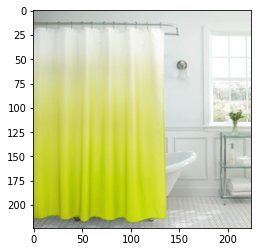

1/1 [==============================] - 0s 69ms/step
98.38% : shower_curtain
 0.77% : window_shade
 0.16% : sliding_door
 0.09% : theater_curtain
 0.05% : tub


In [14]:
href = 'https://images-na.ssl-images-amazon.com/images/I/91NKh-FPcBL._SL1500_.jpg'
path = save_image(href, 'shower_curtain.jpg')
predict(path)

4595/4595 [==============================] - 0s 0us/step


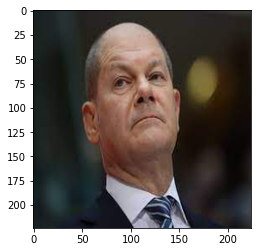

1/1 [==============================] - 0s 60ms/step
72.62% : Windsor_tie
 9.63% : suit
 2.82% : bow_tie
 1.23% : bolo_tie
 1.02% : vestment


In [15]:
href = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTSyfLeumF6lteSh5K4MWtmNeKMD0wFLoP4FfKpesbZFPf5LWxHyN3cSdwWcw9604GmQWw&usqp=CAU'
path = save_image(href, 'scholz.jpg')
predict(path)

В `ImageNet` нет людей. Поэтому можно попробовать выяснить на кого именно ты сильнее всего похож. Чаще всего это будет либо подушка либо занавеска. Если выпадает что-то другое, тебе крупно повезло. 

In [16]:
########################
# Твой код с картинкой
########################

Подгрузим данные и посмотрим на них. Себе данные заберём из гуглового хранилища. Всё тот же волшебный `get_file` из Keras заботливо скачает их для нас и разложит по папочкам вот в такую структуру: 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [17]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip && unzip cats_and_dogs_filtered.zip

--2023-03-01 09:12:12--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  26.7MB/s    in 2.4s    

2023-03-01 09:12:14 (26.7 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/do

In [18]:
!rm cats_and_dogs_filtered.zip
!ls

cats_and_dogs_filtered	sample_data


In [25]:
wd = !pwd
path = wd[0] + '/'

root_train = path + 'cats_and_dogs_filtered/train'
root_test = path + 'cats_and_dogs_filtered/validation'

train_ds = tf.data.Dataset.list_files(root_train + "/*/*.jpg", shuffle=True)

# дробим тест на валидацию и тест
test_list = tf.data.Dataset.list_files(root_test + "/*/*.jpg", shuffle=True)
val_size = 500



In [26]:
test_ds = test_list.skip(val_size)
val_ds = test_list.take(val_size)

In [27]:
import os
INPUT_SHAPE = (224, 224)

def get_label(filename, class_names = ['cats', 'dogs']):
    parts = tf.strings.split(filename, os.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)


def decode_img(img, img_shape=INPUT_SHAPE):
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, img_shape)


def parse_image(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

tf.Tensor(b'/content/cats_and_dogs_filtered/validation/dogs/dog.2448.jpg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64) (224, 224, 3)


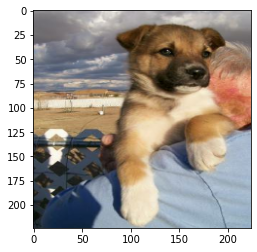

tf.Tensor(b'/content/cats_and_dogs_filtered/validation/dogs/dog.2144.jpg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64) (224, 224, 3)


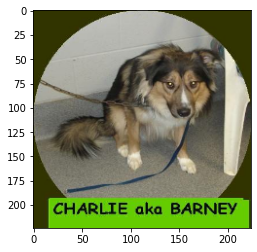

tf.Tensor(b'/content/cats_and_dogs_filtered/validation/dogs/dog.2226.jpg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64) (224, 224, 3)


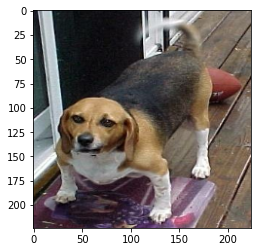

In [28]:
for item in test_ds.take(3):
    print(item)                       # в итераторе путь к конкретной картинке
    image, label = parse_image(item)  # подгрузили картинку 
    print(label, image.shape)                
    plt.imshow(image)                 # нарисовали
    plt.show()

In [29]:
norm_img = lambda x,y: (2*(x - tf.reduce_min(x))/(tf.reduce_max(x) - tf.reduce_min(x)) - 1, y)

def configure_for_performance(ds):
    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(norm_img)
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Применяем к итераторам все преобразования
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# То же самое для теста, но его подгружаем по факту целеком
test_ds = test_ds.map(parse_image).map(norm_img).batch(1000).prefetch(tf.data.AUTOTUNE)

In [30]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 224, 224, 3)
Label:  [0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1]


In [31]:
image.numpy().min(), image.numpy().max()

(-1.0, 1.0)

In [32]:
# построим прогнозы по батчу из картинок
result_batch = model.predict(image)

1/1 [==============================] - 1s 1s/step


In [33]:
# что там у нас спрогнозировалось?
labels_batch = [item[0] for item in zoo.mobilenet_v2.decode_predictions(result_batch)]

In [34]:
labels_batch[:5]

[('n02123045', 'tabby', 0.7110843),
 ('n02092339', 'Weimaraner', 0.15585141),
 ('n02123159', 'tiger_cat', 0.379321),
 ('n02105162', 'malinois', 0.10808316),
 ('n02123045', 'tabby', 0.7948208)]

Посмотрим на  картинки и построенные по ним прогнозы. 

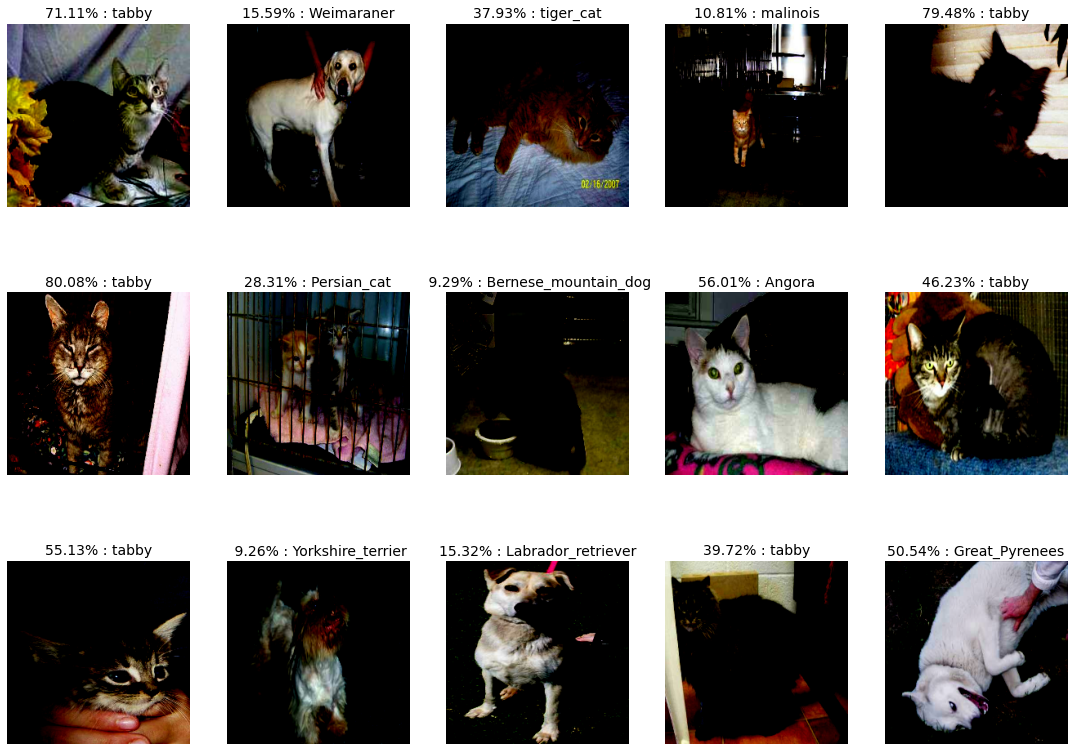

In [35]:
cols = 5
rows = 3
fig = plt.figure(figsize=(4 * cols - 1, 5 * rows - 1))

k = 0 
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(image[k])
        ax.set_title("{0:>6.2%} : {1}".format(labels_batch[k][2], labels_batch[k][1]), size=14)
        k += 1
plt.show()



Предобученная модель не приспособлена для работы с нашими классами. Давайте заставим её их выучить. Для этого нам придётся срезать с сетки её последние слои. Посмотрим на `summary` модели. 

In [36]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Довольно большое полотно.  Обратимся к слою, который мы хотели бы получить по имени. 

In [37]:
transfer_layer = model.get_layer('global_average_pooling2d')

In [38]:
from tensorflow.python.keras.models import Model

# Просто-напросто оформим нужный нам кусок нейросетки как модельку 
# Можно было бы оформить её как отдельный слой (сделаем это ниже)

feature_extractor = Model(
    inputs=model.input,
    outputs=transfer_layer.output
)

In [50]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

# Старт новой модели
new_model = Sequential()

# Первый слой в ней это экстрактор фичей 
new_model.add(Sequential(Dense(3)))
new_model.add(feature_extractor)
new_model.add(Dense(1, activation='sigmoid'))

In [51]:
new_model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['acc']
)

In [52]:
new_model.fit(
    train_ds, validation_data=val_ds,
    epochs=3
)

Epoch 1/3


KeyboardInterrupt: ignored

In [42]:
new_model.predict(image)

array([[0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819],
       [0.4900819]], dtype=float32)